In [ ]:
# Author: Eddie Carrizales
# Date: May 8th, 2024

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d772d583a2c7002da8a3fb6057b2e8905f03eedc4feef897693fad6aebf1c038
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import gdown
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt


# Create SparkSession
spark = SparkSession.builder \
    .appName("Bitcoin Time Series Prediction") \
    .getOrCreate()

# Access SparkContext
sc = spark.sparkContext

url= "https://drive.google.com/file/d/1Uw_R5-8sQ9scSMk9ahczRnccGEPrwO8b/view?usp=sharing"

file_id=url.split('/')[-2]
parsed_url ='https://drive.google.com/uc?id=' + file_id

# Download CSV file using gdown
output = os.path.join(tempfile.gettempdir(), "Bitcoin_Stock_History")
gdown.download(parsed_url, output, quiet=True)

'/tmp/Bitcoin_Stock_History'

In [ ]:
# Load CSV data into an RDD
rdd = sc.textFile(output)

# Show the first few rows of the RDD
#REMOVE THIS WHEN YOU ARE DONE, THIS MAKES IT SMALLER!
rdd = rdd.take(3000000)
#rdd = rdd.take(20000)
rdd = sc.parallelize(rdd)

In [ ]:
#-------------------------pre-processing-------------------------------

In [ ]:
# Assuming you have an RDD named `rdd` containing your data

# Define the indices of the columns you want to keep
#columns_to_keep = [0, 4]  # Assuming Timestamp is at index 0 and Close is at index 4
columns_to_keep = [4]  # Assuming Timestamp is at index 0 and Close is at index 4

# Map each row to a new row with only the desired columns
rdd = rdd.map(lambda row: ','.join([row.split(',')[i] for i in columns_to_keep]))

# Now `rdd_filtered_columns` contains rows with only the desired columns
#rdd.take(10)

In [ ]:
# Assuming you have an RDD named `rdd`
# num_rows = rdd.count()
# print("Number of rows:", num_rows)

In [ ]:
# Assuming you have an RDD named `rdd` containing your data

# Filter out rows containing 'NaN' values
rdd = rdd.filter(lambda row: 'NaN' not in row)

# Now `rdd_without_nan` contains rows without 'NaN' values

In [ ]:
# Assuming you have an RDD named `rdd`
num_rows = rdd.count()
print("Number of rows:", num_rows)

Number of rows: 1804033


In [ ]:
# Show the first few rows of the RDD
#rdd.take(10)

In [ ]:
# Remove the header
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)

#Map function to split each string and convert to int and float
# def convert_to_int_float(data):
#     timestamp, value = data.split(',')
#     return int(timestamp), float(value)

# Convert each string element to float using map
rdd = rdd.map(lambda x: float(x))

# Apply map function
#rdd = rdd.map(convert_to_int_float)
#print(rdd.take(5))

In [ ]:
# Find min and max values
min_val = rdd.min()
max_val = rdd.max()

# Perform Min-Max Scaling
rdd = rdd.map(lambda x: (x - min_val) / (max_val - min_val))
#print(rdd.take(5))

In [ ]:
# Split RDD into training and testing sets (80/20)
#train_rdd, test_rdd = rdd.randomSplit([0.8, 0.2], seed=42)

#print(train_rdd.take(25))
#print(test_rdd.take(25))

In [ ]:
# Assuming rdd is your original RDD

# Count the total number of elements in the RDD
total_count = rdd.count()

# Calculate the split indices
train_count = int(0.8 * total_count)

# Add index to each element in the RDD
rdd_with_index = rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

# Split RDD into training and testing sets
train_rdd = rdd_with_index.filter(lambda x: x[0] < train_count).map(lambda x: x[1])
test_rdd = rdd_with_index.filter(lambda x: x[0] >= train_count).map(lambda x: x[1])

# Print a few elements from each RDD
print(train_rdd.take(25))
print(test_rdd.take(25))


[0.0005805089597239267, 0.0005805089597239267, 0.0006166652271115763, 0.0006186739086331122, 0.0006186739086331122, 0.0006708996281930503, 0.0007030385325376276, 0.0007030385325376276, 0.0007673163412267822, 0.0007311600738391326, 0.0007552642520975655, 0.0007612902966621739, 0.0007612902966621739, 0.0007311600738391326, 0.0007612902966621739, 0.0007612902966621739, 0.000688977761886875, 0.000688977761886875, 0.0007412034814468131, 0.0007412034814468131, 0.0007412034814468131, 0.0007673163412267822, 0.0007673163412267822, 0.0007773597488344625, 0.0008175333792651841]
[0.15043618519240154, 0.1504381938739231, 0.1504381938739231, 0.15071940928693814, 0.15036789002066933, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963, 0.1507495395097612, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963, 0.1507495395097612, 0.15074953950976

In [ ]:
#print(train_rdd.count())
#print(test_rdd.count())

In [ ]:
# Function to partition each partition of the RDD into sequences of length 10, padding the last sequence if needed
def partition_data(iterator):
    result = []
    for x in iterator:
        result.append(x)
        if len(result) == 10:
            yield result
            result = []
    # If there's a remaining partial sequence, pad it
    if result:
        while len(result) < 10:
            result.append(0)  # Padding with zeros for example
        yield result

# Apply mapPartitions
train_rdd = train_rdd.mapPartitions(partition_data)

# Collect the result
result = train_rdd.take(5)

# Print the result
#print(result)

In [ ]:
# Create a new RDD containing the first element of every list, excluding the first list
target_prices = train_rdd.map(lambda lst: lst[0]).zipWithIndex().filter(lambda x: x[1] != 0).map(lambda x: x[0])

In [ ]:
# You can print the results
# print("Train RDD:", train_rdd.take(2))
# print("Target prices for the 11th day:", target_prices.take(5))

# print("Train count", train_rdd.count())
# print("target count", target_prices.count())

In [ ]:
# Function to remove the last value from each partition
def remove_last(split_index, iterator):
    values = list(iterator)
    if split_index == num_partitions - 1:
        return iter(values[:-1])
    else:
        return iter(values)

# Get the number of partitions
num_partitions = train_rdd.getNumPartitions()

# Remove the last value from each partition
train_rdd = train_rdd.mapPartitionsWithIndex(remove_last)

# print("Train count", train_rdd.count())
# print("target count", target_prices.count())

Parameters:
(array([[-0.33905317]]), array([[-0.02100001]]), array([[-0.20851341]]), array([[-0.00549232]]), array([[-0.00010873]]))
Epoch: 0 MSE: [[0.00095376]]


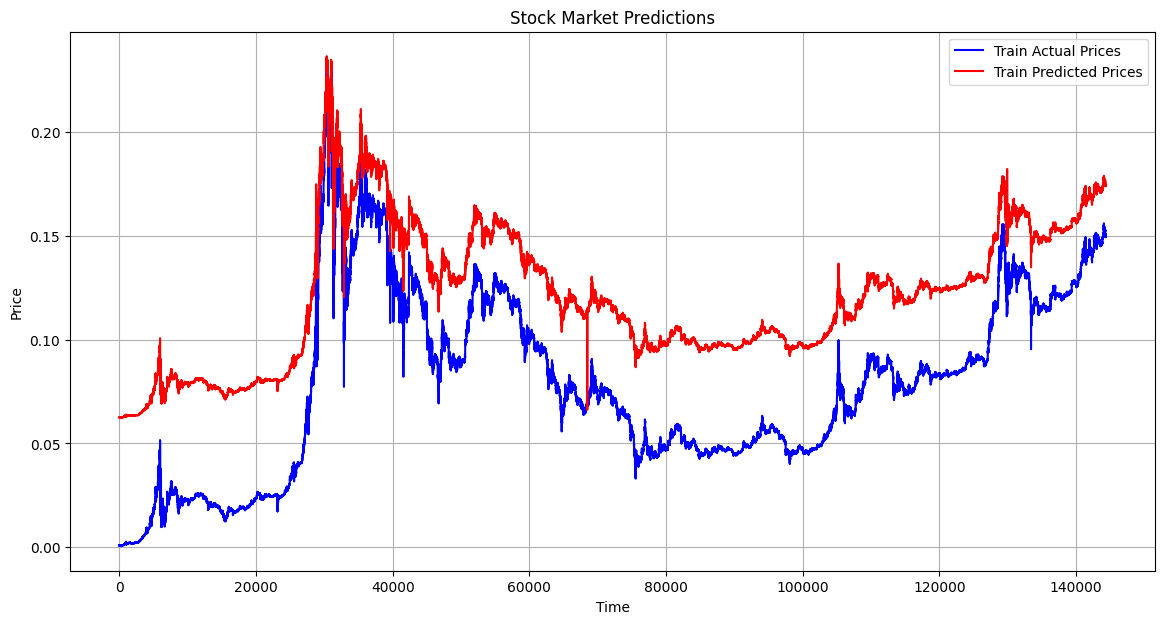

In [ ]:
# Hyperparameters
learning_rate = 0.001

# Define your RNN parameters
# For simplicity, let's assume a basic RNN with only one hidden layer and one neuron
input_size = 1  # Input size (number of features)
hidden_size = 1  # Hidden layer size
output_size = 1  # Output size (predicted price)

W_xh = None
W_hh = None
W_hy = None
b_h = None
b_y = None

# Initialize random weights and biases
def initialize_parameters(input_size, hidden_size, output_size):
    W_xh = np.random.randn(hidden_size, input_size) # Input to hidden weights
    W_hh = np.random.randn(hidden_size, hidden_size) # Hidden to hidden weights
    W_hy = np.random.randn(output_size, hidden_size) # Hidden to output weights
    b_h = np.random.randn(hidden_size, 1)  * 0.01 # Hidden biases
    b_y = np.random.randn(output_size, 1) * 0.01 # Output biases

    return W_xh, W_hh, W_hy, b_h, b_y

# Define your RNN model
def forward_pass(sequence, parameters):
    W_xh, W_hh, W_hy, b_h, b_y = parameters
    # Initialize hidden state
    h_prev = np.zeros((1, 1))

    # Perform forward pass through the RNN
    outputs = []
    for idx, x in enumerate(sequence):
        # Input to activation (dot product of weights with input of timestep t)
        outputIH = np.dot(W_xh, x)

        # Pass input to tanh activation function and update the hidden state
        h_next = np.tanh(outputIH + np.dot(W_hh, h_prev) + b_h)
        outputs.append(h_next)

        # Update hidden state for the next time step
        h_prev = h_next

    # Compute output using the last hidden state
    output = np.dot(W_hy, h_prev) + b_y
    return output, outputs

# Mean Squared Error
def mean_squared_error(pair):
    true_price, predicted_price = pair
    return ((true_price - predicted_price) ** 2) / 2

# Calculate error
def calculate_error(target_prices, predictions):
    # Pair each element of the RDD with its corresponding index
    target_prices_indexed = target_prices.zipWithIndex().map(lambda x: (x[1], x[0]))
    predictions_indexed = predictions.zipWithIndex().map(lambda x: (x[1], x[0]))

    # Ensure both RDDs have the same number of elements in each partition
    combined_data_indexed = target_prices_indexed.join(predictions_indexed)

    # Map Phase: Calculate mean squared error for each pair
    mse_values = combined_data_indexed.map(lambda x: mean_squared_error(x[1]))

    return mse_values

# Backpropagation
def backpropagation(train_data_rdd, target_output, predicted_output, multiple_predictions_rdd, W_hy, W_hh):
    def backprop_sequence(sequence, target_output, predicted_output, multiple_predictions_seq):
        # Initialize gradients for the sequence
        delta_W_xh = np.zeros((1, 1))
        delta_W_hh = np.zeros((1, 1))
        delta_W_hy = np.zeros((1, 1))
        delta_b_h = np.zeros((1, 1))
        delta_b_y = np.zeros((1, 1))

        # Calculate delta for weights and biases
        delta_W_hy_seq = np.dot((predicted_output - target_output), multiple_predictions_seq[-1])
        delta_b_y_seq = predicted_output - target_output

        # Backpropagation through time (BPTT) for the sequence
        dLdOt = np.zeros((1, 1))
        for t in reversed(range(len(sequence))):
            if t == len(sequence) - 1:
                dLdOt = (predicted_output - target_output) * W_hy

            dLdOt = np.dot(dLdOt, (1 - (sequence[t] ** 2)))
            delta_W_xh += dLdOt * sequence[t]

            if t > 0:
                delta_W_hh += dLdOt * sequence[t - 1]

            delta_b_h += dLdOt
            dLdOt = np.dot(W_hh.T, dLdOt)

        return delta_W_xh, delta_W_hh, delta_W_hy_seq, delta_b_h, delta_b_y_seq

    # Create indexed RDDs for each dataset
    train_data_indexed_rdd = train_data_rdd.zipWithIndex().map(lambda x: (x[1], x[0]))
    target_output_indexed_rdd = target_output.zipWithIndex().map(lambda x: (x[1], x[0]))
    predicted_output_indexed_rdd = predicted_output.zipWithIndex().map(lambda x: (x[1], x[0]))
    multiple_predictions_indexed_rdd = multiple_predictions_rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

    # Joining the RDDs
    joined_rdd = (
        train_data_indexed_rdd
        .join(target_output_indexed_rdd)
        .join(predicted_output_indexed_rdd)
        .join(multiple_predictions_indexed_rdd)
    )

    # Mapping the joined elements
    mapped_rdd_part1 = joined_rdd.map(lambda x: (x[1][0][0][0], x[1][0][0][1], x[1][0][1], x[1][1]))

    # Applying backpropagation
    mapped_rdd_part2 = mapped_rdd_part1.map(lambda x: backprop_sequence(x[0], x[1], x[2], x[3]))

    # Reducing the mapped results to aggregate gradients
    delta_grads_rdd = mapped_rdd_part2.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4]))

    return delta_grads_rdd

# Update weights
def update_weights(parameters, gradients, learning_rate):

    W_xh, W_hh, W_hy, b_h, b_y = parameters
    delta_W_xh, delta_W_hh, delta_W_hy, delta_b_h, delta_b_y = gradients

    # Update the weight matrices with gradients
    W_xh -= learning_rate * delta_W_xh
    W_hh -= learning_rate * delta_W_hh
    W_hy -= learning_rate * delta_W_hy

    # Update bias terms
    b_h -= learning_rate * delta_b_h
    b_y -= learning_rate * delta_b_y

    return W_xh, W_hh, W_hy, b_h, b_y

# Train the model
def train(train_rdd, target_prices, parameters):
    # Perform forward pass for each partition
    W_xh, W_hh, W_hy, b_h, b_y = parameters

    predictions_rdd = train_rdd.map(lambda seq: forward_pass(seq, parameters))
    # Collect predictions
    single_predictions = predictions_rdd.map(lambda x: x[0])  # RDD with single predictions
    multiple_predictions = predictions_rdd.map(lambda x: x[1])  # RDD with lists of hidden outputs

    # Calculate error
    loss = calculate_error(target_prices, single_predictions)

    # Call the backpropagation function
    delta_W_xh, delta_W_hh, delta_W_hy, delta_b_h, delta_b_y = backpropagation(train_rdd, target_prices, single_predictions, multiple_predictions, W_hy, W_hh)

    # Update the weights
    new_parameters = update_weights(parameters, (delta_W_xh, delta_W_hh, delta_W_hy, delta_b_h, delta_b_y), learning_rate)

    print("Epoch:", epoch, "MSE:", loss.mean())

    # Plotting
    target_prices_list = target_prices.collect()
    single_predictions_list = single_predictions.collect()
    single_predictions.unpersist()

    # Assuming predictions is the list of arrays
    flattened_predictions = [prediction[0][0] for prediction in single_predictions_list]

    plt.figure(figsize=(14, 7))
    plt.plot(target_prices_list, label='Train Actual Prices', color='blue')
    plt.plot(flattened_predictions, label='Train Predicted Prices', color='red')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Stock Market Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

    return new_parameters

# History over epochs
parameters = initialize_parameters(input_size, hidden_size, output_size)
print("Parameters:")
print(parameters)

num_epochs = 1

# Train the model
# ---------------------------SAVING PARAMETERS(WEIGHTS) OF BEST MODEL TRAINED----------------------
parameters = [-0.7735524, -0.28759165, -1.25382619, -0.02337621, 0.03910023]# really good weights found
parameters = np.array(parameters)
# ---------------------------------------------------------------------------------

for epoch in range(num_epochs):
    new_parameters = train(train_rdd, target_prices, parameters)
    parameters = new_parameters

In [ ]:
# Test portion

In [ ]:
# Function to partition each partition of the RDD into sequences of length 10, padding the last sequence if needed
def partition_data(iterator):
    result = []
    for x in iterator:
        result.append(x)
        if len(result) == 10:
            yield result
            result = []
    # If there's a remaining partial sequence, pad it
    if result:
        while len(result) < 10:
            result.append(0)  # Padding with zeros for example
        yield result

# Apply mapPartitions
test_rdd = test_rdd.mapPartitions(partition_data)

# Collect the result
result = test_rdd.take(5)

# Print the result
print(result)

[[0.15043618519240154, 0.1504381938739231, 0.1504381938739231, 0.15071940928693814, 0.15036789002066933, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963], [0.1507495395097612, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963, 0.1507495395097612], [0.1507495395097612, 0.15074753082823963, 0.15074753082823963, 0.15074753082823963, 0.15039802024349236, 0.15066919224889974, 0.15048238486739687, 0.15060893180325363, 0.15058281894347367, 0.15058281894347367], [0.15072141796845967, 0.15069128774563664, 0.15057478421738754, 0.15070735719780892, 0.1506953051086797, 0.15049041959348303, 0.15069932247172277, 0.1507013311532443, 0.1505225584978276, 0.15036789002066933], [0.1506732096119428, 0.15037391606523393, 0.15040203760653542, 0.15062098389238288, 0.15036387265762627, 0.15064910543368437, 0.15065714015977053, 0.15065714015977053

In [ ]:
# Create a new RDD containing the first element of every list, excluding the first list
test_target_prices = test_rdd.map(lambda lst: lst[0]).zipWithIndex().filter(lambda x: x[1] != 0).map(lambda x: x[0])

In [ ]:
# You can print the results
print("Test RDD:", test_rdd.take(2))
print("Target prices for the 11th day:", test_target_prices.take(5))

print("Test count", test_rdd.count())
print("Test target count", test_target_prices.count())

Test RDD: [[0.15043618519240154, 0.1504381938739231, 0.1504381938739231, 0.15071940928693814, 0.15036789002066933, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963], [0.1507495395097612, 0.15074753082823963, 0.15074753082823963, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.1507495395097612, 0.15074753082823963, 0.1507495395097612]]
Target prices for the 11th day: [0.1507495395097612, 0.1507495395097612, 0.15072141796845967, 0.1506732096119428, 0.15066517488585668]
Test count 36081
Test target count 36080


In [ ]:
# Function to remove the last value from each partition
def remove_last(split_index, iterator):
    values = list(iterator)
    if split_index == num_partitions - 1:
        return iter(values[:-1])
    else:
        return iter(values)

# Get the number of partitions
num_partitions = test_rdd.getNumPartitions()

# Remove the last value from each partition
test_rdd = test_rdd.mapPartitionsWithIndex(remove_last)

print("Train count", test_rdd.count())
print("Test target count", test_target_prices.count())

Train count 36080
Test target count 36080


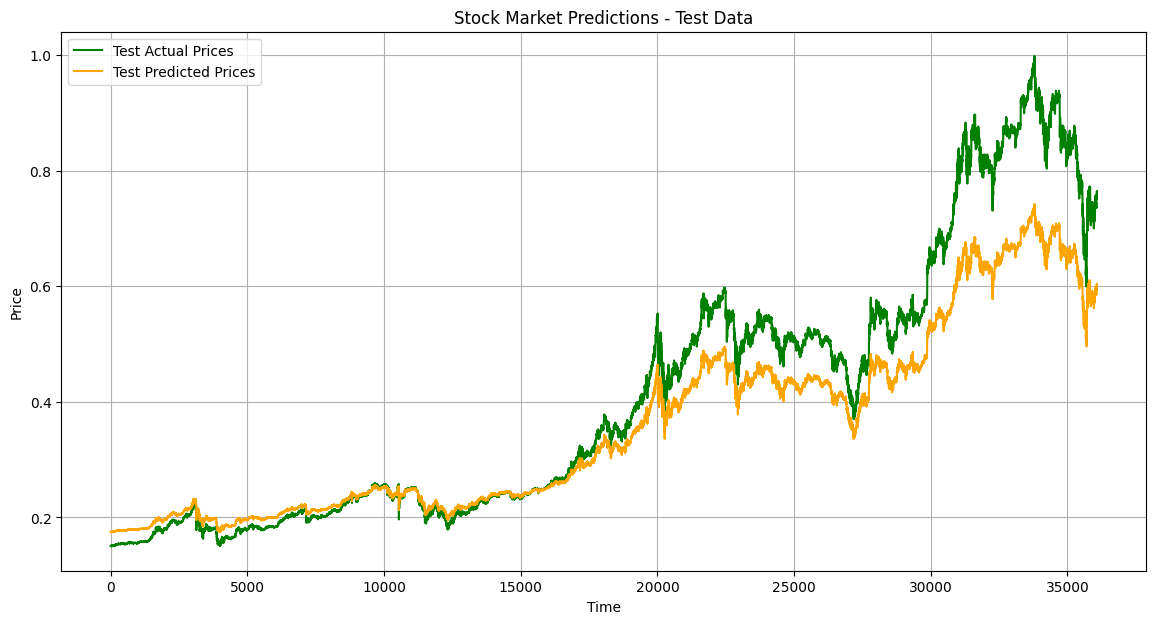

Overall Test MSE: [[0.00383553]]


In [ ]:
# ---------------------------SAVING PARAMETERS(WEIGHTS) OF BEST MODEL TRAINED----------------------
parameters = [-0.7735524, -0.28759165, -1.25382619, -0.02337621, 0.03910023]# really good weights found
parameters = np.array(parameters)
# ---------------------------------------------------------------------------------

def test(test_rdd, target_prices, parameters):
    # Perform forward pass for each partition
    predictions_rdd = test_rdd.map(lambda seq: forward_pass(seq, parameters))

    # Collect predictions
    single_predictions = predictions_rdd.map(lambda x: x[0])  # RDD with single predictions

    # Calculate error
    loss = calculate_error(target_prices, single_predictions)

    # Plotting
    target_prices_list = target_prices.collect()
    single_predictions_list = single_predictions.collect()

    # Assuming predictions is the list of arrays
    flattened_predictions = [prediction[0][0] for prediction in single_predictions_list]

    plt.figure(figsize=(14, 7))
    plt.plot(target_prices_list, label='Test Actual Prices', color='green')
    plt.plot(flattened_predictions, label='Test Predicted Prices', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Stock Market Predictions - Test Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    return loss.mean()

# Assuming you have test data in RDD format
test_loss = test(test_rdd, test_target_prices, parameters)
print("Overall Test MSE:", test_loss)
